# Racism on Recent Killings

### Context

In the recent killings, a hot topic came into being, "Racism".
So, I chose to gather some data to take out some insights and analyze the story around racism in America.


### Content


It contains basic data about people like their name, age, gender and race. Along with it, is the shooting/killing information, like date of event, where it happened? how they were shot? did they attack? Were they holding weapons? Did they show any mental illness? Was the policeman wearing a camera/was the incident recorded? Did the suspect flee? Apart from that, a category column holds type of weapon used by the suspect


## Introduction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

df = pd.read_csv('shootings.csv')

We first take a look at the variables we will be working with:

In [2]:
df.head()

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,arms_category
0,3,Tim Elliot,2015-01-02,shot,gun,53.0,M,Asian,Shelton,WA,True,attack,Not fleeing,False,Guns
1,4,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,M,White,Aloha,OR,False,attack,Not fleeing,False,Guns
2,5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.0,M,Hispanic,Wichita,KS,False,other,Not fleeing,False,Unarmed
3,8,Matthew Hoffman,2015-01-04,shot,toy weapon,32.0,M,White,San Francisco,CA,True,attack,Not fleeing,False,Other unusual objects
4,9,Michael Rodriguez,2015-01-04,shot,nail gun,39.0,M,Hispanic,Evans,CO,False,attack,Not fleeing,False,Piercing objects


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4895 entries, 0 to 4894
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       4895 non-null   int64  
 1   name                     4895 non-null   object 
 2   date                     4895 non-null   object 
 3   manner_of_death          4895 non-null   object 
 4   armed                    4895 non-null   object 
 5   age                      4895 non-null   float64
 6   gender                   4895 non-null   object 
 7   race                     4895 non-null   object 
 8   city                     4895 non-null   object 
 9   state                    4895 non-null   object 
 10  signs_of_mental_illness  4895 non-null   bool   
 11  threat_level             4895 non-null   object 
 12  flee                     4895 non-null   object 
 13  body_camera              4895 non-null   bool   
 14  arms_category           

Some adjustements we could make, would be to:

1. Change 'date' to dt
2. Set the 'id' to be the index
3. Check if 'flee' can be turned to bool

In [4]:
df['date'] = pd.to_datetime(df['date'],format = '%Y-%m-%d')
df['date'].head()

0   2015-01-02
1   2015-01-02
2   2015-01-03
3   2015-01-04
4   2015-01-04
Name: date, dtype: datetime64[ns]

In [5]:
print(df['id'].unique().shape) #There are 4895 registers, equal to the total number of rows.
df.index = df['id']
df.drop('id', inplace = True, axis = 1)
df.head()

(4895,)


,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,arms_category
id,,,,,,,,,,,,,,
3,Tim Elliot,2015-01-02,shot,gun,53.0,M,Asian,Shelton,WA,True,attack,Not fleeing,False,Guns
4,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,M,White,Aloha,OR,False,attack,Not fleeing,False,Guns
5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.0,M,Hispanic,Wichita,KS,False,other,Not fleeing,False,Unarmed
8,Matthew Hoffman,2015-01-04,shot,toy weapon,32.0,M,White,San Francisco,CA,True,attack,Not fleeing,False,Other unusual objects
9,Michael Rodriguez,2015-01-04,shot,nail gun,39.0,M,Hispanic,Evans,CO,False,attack,Not fleeing,False,Piercing objects


In [6]:
df['flee'].describe() #There are 4 unique kinds, so perhaps the variable can't be turned to bool.

count            4895
unique              4
top       Not fleeing
freq             3073
Name: flee, dtype: object

In [7]:
print(df['flee'].unique())
df['flee'].value_counts() #Whilst we can't turn this one into bool, we can create a new one that captures this

['Not fleeing' 'Car' 'Foot' 'Other']


Not fleeing    3073
Car             820
Foot            642
Other           360
Name: flee, dtype: int64

In [8]:
df['was_fleeing'] = [x != 'Not fleeing' for x in df['flee']]
print(df['was_fleeing'].unique())
df['was_fleeing'].describe()

[False  True]


count      4895
unique        2
top       False
freq       3073
Name: was_fleeing, dtype: object

Given the purpose of what we are trying to verify, that is, if the recent killings have been influenced by racial prejudices, we can start by looking at the most obvious plot: The amount of people killed by race.

<AxesSubplot:>

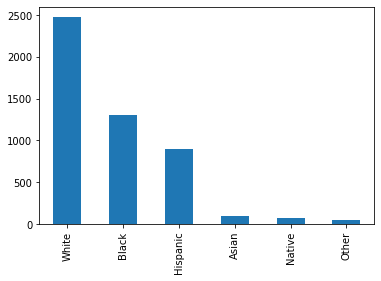

In [9]:
df['race'].value_counts().plot(kind = 'bar')

However, this is a misleading plot. The reason for this is that, the majority of the US population is white, so we can't just decide based on totals. For this reason, we need to know the total population from each race, so that we can rather look at the proportion of people killed with respect to the total population, by race, which is way more useful than only the totals.

## Mining and Wrangling

#### Note: The following code and text is mostly dedicated to data mining and some wrangling. There is a note on where the analysis is retaken.

We will use the information of race by state that can be found on Wikipedia's entry for 'Demographics of the United States' (url : https://en.wikipedia.org/wiki/Demographics_of_the_United_States#cite_note-ACS-94 )

The information that will be used is the following: Racial breakdown of population by state (plus D.C. and Puerto Rico), 2015.<sup>i</sup> The table contains data for every race except Latino/Hispanic, for which we have a classification in our dataset (the data in Wikipedia, more specifically the U.S. Office of Management and Budget (OMB), classifies Latino/Hispanic not as a race, but rather as a classification for 'origin').

Also, I will use the code provided in https://www.thinkingondata.com/web-scraping-wikipedia-using-beautiful-soup/ , as I will be using BeautifulSoup to acquire the data, with a few modifications to achieve what we want

Notice, to replicate this it is necessary to install bs4 (type in terminal: python -m pip install bs4)

In [10]:
# import the library we use to open URLs
import urllib.request

# import the BeautifulSoup library so we can parse HTML and XML documents
from bs4 import BeautifulSoup

# specify which URL/web page we are going to be scraping
url = "https://en.wikipedia.org/wiki/Demographics_of_the_United_States#cite_note-ACS-94"

# open the url using urllib.request and put the HTML into the page variable
page = urllib.request.urlopen(url)

# parse the HTML from our URL into the BeautifulSoup parse tree format
soup = BeautifulSoup(page, "html.parser")

all_tables = soup.find_all("table")

In [11]:
#Auxiliar empty lists
A=[]
B=[]
C=[]
D=[]
E=[]
F=[]
G=[]
H=[]
I=[]

#We counted the number of tables preceding the one we are looking for on the Wikipedia page,
#and found that we needed all_tables[27] 
for row in all_tables[27].findAll('tr'):
    cells=row.findAll('td')
    if len(cells)==9:
        A.append(cells[0].text.strip())
        B.append(cells[1].text.strip()) 
        C.append(cells[2].text.strip())
        D.append(cells[3].text.strip())
        E.append(cells[4].text.strip())
        F.append(cells[5].text.strip())
        G.append(cells[6].text.strip())
        H.append(cells[7].text.strip())
        I.append(cells[8].text.strip())

#And we store everything on DF
pop=pd.DataFrame(A,columns=['a'])
pop['b']=B
pop['c']=C
pop['d']=D
pop['e']=E
pop['f']=F
pop['g']=G
pop['h']=H
pop['i']=I

#We want the actual names of the columns to help us associate them later
cell = all_tables[27].findAll('th')
aux = []
for i, value in enumerate(cell):
    aux.append(cell[i].text.strip())
    
pop.columns = aux
pop.head()

,State or territory,Population(2015 est.),White,Black orAfrican American,American Indianand Alaska Native,Asian,Native Hawaiian andOther Pacific Islander,Some other race,Two or more races
0,Alabama,"4,830,620",68.8%,26.4%,0.5%,1.2%,0.1%,1.3%,1.7%
1,Alaska,"733,375",66.0%,3.4%,13.8%,5.9%,1.2%,1.3%,8.4%
2,Arizona,"6,641,928",78.4%,4.2%,4.4%,3.0%,0.2%,6.5%,3.2%
3,Arkansas,"2,958,208",78.0%,15.5%,0.6%,1.4%,0.2%,2.1%,2.1%
4,California,"38,421,464",61.8%,5.9%,0.7%,13.7%,0.4%,12.9%,4.5%


In [12]:
pop.head()

,State or territory,Population(2015 est.),White,Black orAfrican American,American Indianand Alaska Native,Asian,Native Hawaiian andOther Pacific Islander,Some other race,Two or more races
0,Alabama,"4,830,620",68.8%,26.4%,0.5%,1.2%,0.1%,1.3%,1.7%
1,Alaska,"733,375",66.0%,3.4%,13.8%,5.9%,1.2%,1.3%,8.4%
2,Arizona,"6,641,928",78.4%,4.2%,4.4%,3.0%,0.2%,6.5%,3.2%
3,Arkansas,"2,958,208",78.0%,15.5%,0.6%,1.4%,0.2%,2.1%,2.1%
4,California,"38,421,464",61.8%,5.9%,0.7%,13.7%,0.4%,12.9%,4.5%


In [13]:
df['race'].unique()

array(['Asian', 'White', 'Hispanic', 'Black', 'Other', 'Native'],
      dtype=object)

In [14]:
pop2 = pop.copy()

#we change the name of the following column to 'Black'
pop2.rename(columns = {'Black orAfrican American' : 'Black'}, inplace = True)

#We convert everything to numeric, removing characters that get in the way
pop2.iloc[:,2:] = pop2.iloc[:,2:].apply(lambda x: x.str.strip('%'))
pop2.iloc[:,2:] = pop2.iloc[:,2:].apply(lambda x: x.str.replace('.',''))
pop2.iloc[:,1] = pop2.iloc[:,1].apply(lambda x : x.replace(',',''))
pop2.iloc[:,1:] = pop2.iloc[:,1:].astype(str).astype(float)
pop2.iloc[:,2:] = pop2.iloc[:,2:].apply(lambda x: x.astype('float')/1000)

#We create the 'Native' column by merging the following 2:
pop2['Native'] = pop2['American Indianand Alaska Native'] + pop2['Native Hawaiian andOther Pacific Islander']
pop2.drop(['American Indianand Alaska Native','Native Hawaiian andOther Pacific Islander'], inplace = True, axis = 1)

#We assume that 'Some other race' accounts for 'Other'
pop2.rename(columns = {'Some other race' : 'Other'}, inplace = True)

#And we distribute the 'Two or more races' uniformly due to lack of further knolwedge about it
pop2['White'] = pop2['White'] + pop2['Two or more races']/5
pop2['Black'] = pop2['Black'] + pop2['Two or more races']/5
pop2['Asian'] = pop2['Asian'] + pop2['Two or more races']/5
pop2['Other'] = pop2['Other'] + pop2['Two or more races']/5
pop2['Native'] = pop2['Native'] + pop2['Two or more races']/5
pop2.drop('Two or more races', inplace = True, axis = 1)

pop = pop2
pop.head()
# pop.as_type(pop.iloc[:,1:]))
# pop2.dtypes

,State or territory,Population(2015 est.),White,Black,Asian,Other,Native
0,Alabama,4.83062e+06,0.6914,0.2674,0.0154,0.0164,0.0094
1,Alaska,733375,0.6768,0.0508,0.0758,0.0298,0.1668
2,Arizona,6.64193e+06,0.7904,0.0484,0.0364,0.0714,0.0524
3,Arkansas,2.95821e+06,0.7842,0.1592,0.0182,0.0252,0.0122
4,California,3.84215e+07,0.627,0.068,0.146,0.138,0.02


Notice we are still lacking 'Hispanic', but we will fix that later

Also, we need a way to associate the States to their codings. Again, we use Wikipedia (url : https://en.wikipedia.org/wiki/List_of_U.S._state_and_territory_abbreviations) and BeautifulSoup.

In [15]:
# import the library we use to open URLs
import urllib.request

# import the BeautifulSoup library so we can parse HTML and XML documents
from bs4 import BeautifulSoup

# specify which URL/web page we are going to be scraping
url = "https://en.wikipedia.org/wiki/List_of_U.S._state_and_territory_abbreviations"

# open the url using urllib.request and put the HTML into the page variable
page = urllib.request.urlopen(url)

# parse the HTML from our URL into the BeautifulSoup parse tree format
soup = BeautifulSoup(page, "html.parser")

all_tables_states = soup.find_all("table")

In [16]:
#Auxiliar empty lists
A=[]
B=[]


#We counted the number of tables preceding the one we are looking for on the Wikipedia page,
#and found that we needed all_tables[27] 
for row in all_tables_states[0].findAll('tr'):
    cells=row.findAll('td')
    if len(cells)==10:
        A.append(cells[0].text.strip())
        B.append(cells[3].text.strip()) 
       

#And we store everything on DF, plus, we name the second column 'state' so as to facilitate the join
st=pd.DataFrame(A,columns=['StateName'])
st['state']=B
st.index = st['state']
st.drop('state', inplace = True, axis = 1)
st.head()

,StateName
state,
US,United States of America
AL,Alabama
AK,Alaska
AZ,Arizona
AR,Arkansas


We substitue the state acronym to its full name

In [17]:
df = df.replace({'state':st.to_dict()['StateName']})
df.head()

,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,arms_category,was_fleeing
id,,,,,,,,,,,,,,,
3,Tim Elliot,2015-01-02,shot,gun,53.0,M,Asian,Shelton,Washington,True,attack,Not fleeing,False,Guns,False
4,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,M,White,Aloha,Oregon,False,attack,Not fleeing,False,Guns,False
5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.0,M,Hispanic,Wichita,Kansas,False,other,Not fleeing,False,Unarmed,False
8,Matthew Hoffman,2015-01-04,shot,toy weapon,32.0,M,White,San Francisco,California,True,attack,Not fleeing,False,Other unusual objects,False
9,Michael Rodriguez,2015-01-04,shot,nail gun,39.0,M,Hispanic,Evans,Colorado,False,attack,Not fleeing,False,Piercing objects,False


In [18]:
print(df['state'].unique()) #We check that every state was mapped
df['state'].isna().sum()

['Washington' 'Oregon' 'Kansas' 'California' 'Colorado' 'Oklahoma'
 'Arizona' 'Iowa' 'Pennsylvania' 'Texas' 'Ohio' 'Louisiana' 'Montana'
 'Utah' 'Arkansas' 'Illinois' 'Nevada' 'New Mexico' 'Minnesota' 'Missouri'
 'Virginia' 'New Jersey' 'Indiana' 'Kentucky' 'Massachusetts'
 'New Hampshire' 'Florida' 'Idaho' 'Maryland' 'Nebraska' 'Michigan'
 'Georgia' 'Tennessee' 'North Carolina' 'Alaska' 'New York' 'Maine'
 'Alabama' 'Mississippi' 'Wisconsin' 'South Carolina' 'Delaware'
 'District of Columbia' 'West Virginia' 'Hawaii' 'Wyoming' 'North Dakota'
 'Connecticut' 'South Dakota' 'Vermont' 'Rhode Island']


0

Before moving on, given the statemant mentioned above about Latino/Hispanic, we will make an estimate on the number of Latino/Hispanic given the information available on another table also in the Wikipedia page:

In [19]:
#Auxiliar empty lists
M=[]
N=[]
O=[]

#We counted the number of tables preceding the one we are looking for on the Wikipedia page,
#and found that we needed all_tables[27] 
for row in all_tables[33].findAll('tr'):
    cells=row.findAll('td')
    if len(cells)==3:
        M.append(cells[0].text.strip())
        N.append(cells[1].text.strip()) 
        O.append(cells[2].text.strip())
        
#And we store everything on DF
his=pd.DataFrame(M,columns=['a'])
his['b']=N
his['c']=O

#We want the actual names of the columns to help us associate them later
cell = all_tables[33].findAll('th')
aux = []
for i, value in enumerate(cell):
    aux.append(cell[i].text.strip())
    
his.columns = aux
his.index = his['Hispanic or Latino and Race']
his.drop('Hispanic or Latino and Race', inplace = True, axis = 1)
his

,Population (2015 est.),Percentage of total population
Hispanic or Latino and Race,,
United States population,"316,515,021",100%
Hispanic or Latino (of any race),"54,232,205",17.1%
White,"35,684,777",11.3%
Black or African American,"1,122,369",0.3%
American Indian and Alaska Native,"490,557",0.1%
Asian,"181,231",0.0%
Native Hawaiian and Other Pacific Islander,"46,724",0.0%
Some other race,"14,226,829",4.5%
Two or more races,"2,479,718",0.8%


We assume, given the lack of information, that the Hispanic 'race' distribution is the same for every State.

In [20]:
df['race'].unique()

array(['Asian', 'White', 'Hispanic', 'Black', 'Other', 'Native'],
      dtype=object)

In [21]:
his.loc[['White',
         'Black or African American',
         'American Indian and Alaska Native',
         'Asian','Native Hawaiian and Other Pacific Islander',
         'Some other race',
         'Two or more races'],:]

,Population (2015 est.),Percentage of total population
Hispanic or Latino and Race,,
White,"35,684,777",11.3%
Black or African American,"1,122,369",0.3%
American Indian and Alaska Native,"490,557",0.1%
Asian,"181,231",0.0%
Native Hawaiian and Other Pacific Islander,"46,724",0.0%
Some other race,"14,226,829",4.5%
Two or more races,"2,479,718",0.8%


In [22]:
his2 = his.copy()

#We make similar transformations to this df as in the pop df
his2['Percentage of total population'] = his2['Percentage of total population'].apply(lambda x: x.strip('%'))
his2['Percentage of total population'] = his2['Percentage of total population'].apply(lambda x: x.replace('.',''))
his2.drop('Population (2015 est.)', inplace = True,axis = 1)
his2 = his2.transpose()
his2.drop(['United States population',
           'Hispanic or Latino (of any race)',
           'Not Hispanic or Latino'],inplace = True,axis = 1)
his2 = his2.astype('float')/1000
his2.rename(columns = {'Black or African American' : 'Black',
                      'Some other race' : 'Other'}, inplace = True)
his2['Native'] = his2['American Indian and Alaska Native'] + his2['Native Hawaiian and Other Pacific Islander']
his2.drop(['American Indian and Alaska Native','Native Hawaiian and Other Pacific Islander'], inplace = True, axis = 1)
his2['White'] = his2['White'] + his2['Two or more races']/5
his2['Black'] = his2['Black'] + his2['Two or more races']/5
his2['Asian'] = his2['Asian'] + his2['Two or more races']/5
his2['Other'] = his2['Other'] + his2['Two or more races']/5
his2['Native'] = his2['Native'] + his2['Two or more races']/5
his2.drop('Two or more races', inplace = True, axis = 1)

his = his2
his.head()

Hispanic or Latino and Race,White,Black,Asian,Other,Native
Percentage of total population,0.1146,0.0046,0.0016,0.0466,0.0026


With the vector above, we can add a new column, 'Hispanic', to the matrix of population by race and state

In [23]:
pop2 = pop.copy()
races = ['White','Black','Asian','Other','Native']

# We use tha same distribution for every state to create the 'Hispanic' column
pop2['Hispanic'] = np.array(pop2[races]).dot(np.array(his.transpose()))

#And then remove the percentage we took from every other 'race' column
for race in races:
    f = (1-his[race])
    pop2[race] = (pop2[race].astype('float'))*f[0]

pop = pop2
pop.head()

,State or territory,Population(2015 est.),White,Black,Asian,Other,Native,Hispanic
0,Alabama,4.83062e+06,0.612166,0.266170,0.015375,0.015636,0.009376,0.0812778
1,Alaska,733375,0.599239,0.050566,0.075679,0.028411,0.166366,0.0797386
2,Arizona,6.64193e+06,0.699820,0.048177,0.036342,0.068073,0.052264,0.0943242
3,Arkansas,2.95821e+06,0.694331,0.158468,0.018171,0.024026,0.012168,0.0918368
4,California,3.84215e+07,0.555146,0.067687,0.145766,0.131569,0.019948,0.0788834


In [24]:
# We add columns that will be useful to our pop df:
races = ['White','Black','Asian','Other','Native','Hispanic']

for race in races:
    race_pop = race + ' Pop'
    pop[race_pop] = pop['Population(2015 est.)']*pop[race]

pop.head()

,State or territory,Population(2015 est.),White,Black,Asian,Other,Native,Hispanic,White Pop,Black Pop,Asian Pop,Other Pop,Native Pop,Hispanic Pop
0,Alabama,4.83062e+06,0.612166,0.266170,0.015375,0.015636,0.009376,0.0812778,2.95714e+06,1.28577e+06,74272.5,75530.4,45289.8,392622
1,Alaska,733375,0.599239,0.050566,0.075679,0.028411,0.166366,0.0797386,439467,37084.1,55500.9,20836.2,122009,58478.3
2,Arizona,6.64193e+06,0.699820,0.048177,0.036342,0.068073,0.052264,0.0943242,4.64816e+06,319991,241379,452134,347132,626495
3,Arkansas,2.95821e+06,0.694331,0.158468,0.018171,0.024026,0.012168,0.0918368,2.05397e+06,468780,53753.2,71073,35996.3,271672
4,California,3.84215e+07,0.555146,0.067687,0.145766,0.131569,0.019948,0.0788834,2.13295e+07,2.60064e+06,5.60056e+06,5.05508e+06,766431,3.03082e+06


#### Note: Analysis starts here.

## Analysis

Now that we have obtained the information about the population, we are able to observe the proportion of people killed to total amount of population, by race. Let's begin first with an overall look, that is, let's get averages for the whole US.

<AxesSubplot:>

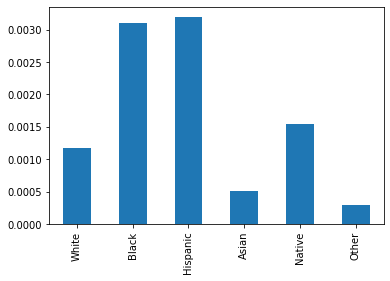

In [25]:
#We obtain the total amount of deaths by race
df_total = df['race'].value_counts()

#We get the total population by race
aux = []
races = ['White','Black','Hispanic','Asian','Native','Other']
for race in races:
    aux.append(pop[race + ' Pop'].sum())

df_total = pd.DataFrame({'Deaths': df_total, 'Population': aux})

#And we get the proportion and plot it
df_total['Deaths/Population %'] = (df_total['Deaths']/df_total['Population'])*100
df_total['Deaths/Population %'].plot(kind = 'bar')

The difference with the previous graph is clear: The proportion of deaths to population is much higher when it comes to black and hispanic races, and even the natives seem to have a higher proportion than whites.

,Deaths,Population,Deaths/Population %
White,2476.0,2.101825e+08,0.001178
Black,1298.0,4.194607e+07,0.003094
Hispanic,902.0,2.824462e+07,0.003194
Asian,93.0,1.818129e+07,0.000512
Native,78.0,5.045872e+06,0.001546
Other,48.0,1.644792e+07,0.000292
Total,4895.0,3.200482e+08,0.001529


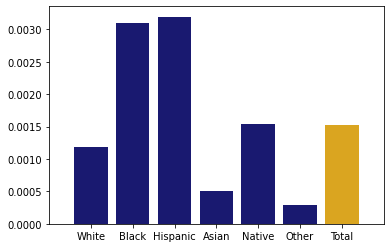

In [26]:
#We add a Total row, to check what would be the expected value given there was no bias by race
df_total.loc['Total',:] = df_total.sum(axis = 0)# (total_deaths/total_pop)*100
df_total.loc['Total','Deaths/Population %'] = 100*df_total.loc['Total','Deaths']/df_total.loc['Total','Population']

#And plot it along the other
x_pos = np.arange(len(df_total['Deaths']))
plt.bar(x_pos, df_total['Deaths/Population %'], color = ['midnightblue',
                                                         'midnightblue',
                                                         'midnightblue',
                                                         'midnightblue',
                                                         'midnightblue',
                                                         'midnightblue',
                                                         'goldenrod'])
plt.xticks(x_pos, df_total.index)
plt.xlim((-1,len(df_total['Deaths']-1)))
df_total


So, we can visually see that there is a clear bias towards black and hispanic people, possibly indicating a racism factor in the killings

It is of interest, as if there has been more racism in the recent years. Let's check visually first:

In [27]:
#We create a year index
df['Year'] = pd.DatetimeIndex(df['date']).year

def plot_deaths_per_pop(df):
    #We obtain the total amount of deaths by race
    df_total = df['race'].value_counts()

    #We get the total population by race
    aux = []
    races = ['White','Black','Hispanic','Asian','Native','Other']
    for race in races:
        aux.append(pop[race + ' Pop'].sum())

    df_total = pd.DataFrame({'Deaths': df_total, 'Population': aux})

    #And we get the proportion
    df_total['Deaths/Population %'] = (df_total['Deaths']/df_total['Population'])*100

    #We add a Total row, to check what would be the expected value given there was no bias by race
    df_total.loc['Total',:] = df_total.sum(axis = 0)# (total_deaths/total_pop)*100
    df_total.loc['Total','Deaths/Population %'] = 100*df_total.loc['Total','Deaths']/df_total.loc['Total','Population']

    #And plot it along the other
    x_pos = np.arange(len(df_total['Deaths']))
    plt.bar(x_pos, df_total['Deaths/Population %'], color = ['midnightblue',
                                                             'midnightblue',
                                                             'midnightblue',
                                                             'midnightblue',
                                                             'midnightblue',
                                                             'midnightblue',
                                                             'goldenrod'])
    plt.xlim((-1,len(df_total['Deaths']-1)))
    plt.xticks(x_pos, df_total.index)

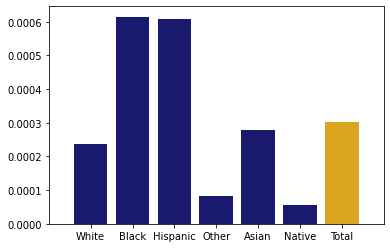

In [28]:
plot_deaths_per_pop(df[df['Year'] == 2015])

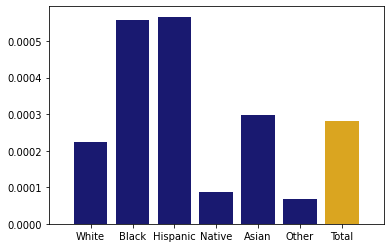

In [29]:
plot_deaths_per_pop(df[df['Year'] == 2016])

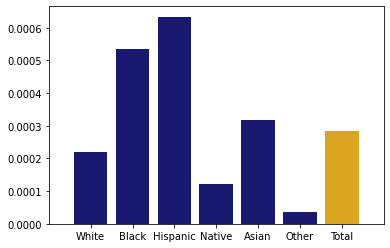

In [30]:
plot_deaths_per_pop(df[df['Year'] == 2017])

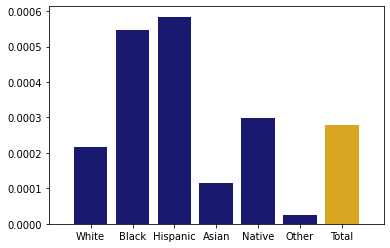

In [31]:
plot_deaths_per_pop(df[df['Year'] == 2018])

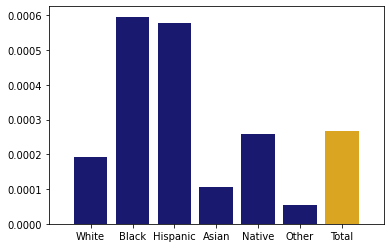

In [32]:
plot_deaths_per_pop(df[df['Year'] == 2019])

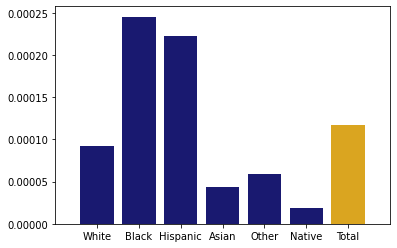

In [33]:
plot_deaths_per_pop(df[df['Year'] == 2020])

Just by looking at the graphs, there really seems there is not a time component in the deaths per popolation.

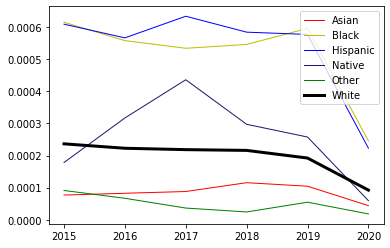

In [34]:
# df_total = df[['race','Year']].value_counts()
df_total = df.groupby(['Year','race']).count()
df_total = df_total['name']

#We get the total population by race
aux = []
races = ['Asian','Black','Hispanic','Native','Other', 'White']*6
for race in races:
    aux.append(pop[race + ' Pop'].sum())

df_total = pd.DataFrame({'Deaths': df_total, 'Population': aux})

#And we get the proportion and plot it
df_total['Deaths/Population %'] = (df_total['Deaths']/df_total['Population'])*100

#We
n = np.arange(6)
colors = ['r','y','b','midnightblue','g','black']
linewidths = [1,1,1,1,1,3]
for race,color,linewidth in zip(races,colors,linewidths):
    plt.plot(n,
             df_total.loc[([2015,2016,2017,2018,2019,2020],[race]),'Deaths/Population %'],
             color,
             linewidth = linewidth)
    
plt.xticks(n,[2015,2016,2017,2018,2019,2020])
plt.legend(races)
plt.show()

We can see than see that on the year 2017, there seemed to be an increase tendency on Hispanic and Native people being killed. On later years, the tendency for Native people drastically went down, yet for Hispanics it was just reduced a by a little. On the contrary, the tendency for Black people seemed to be lowering, but it even went over Hispanic people on 2019.

We will now proceed to make a Logistic Regression, where the response variable will be: White vs Not White, and try to understand the influence that other variables. To choose which variables could be useful, we should take a look at them:

In [35]:
df.head()

,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,arms_category,was_fleeing,Year
id,,,,,,,,,,,,,,,,
3,Tim Elliot,2015-01-02,shot,gun,53.0,M,Asian,Shelton,Washington,True,attack,Not fleeing,False,Guns,False,2015
4,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,M,White,Aloha,Oregon,False,attack,Not fleeing,False,Guns,False,2015
5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.0,M,Hispanic,Wichita,Kansas,False,other,Not fleeing,False,Unarmed,False,2015
8,Matthew Hoffman,2015-01-04,shot,toy weapon,32.0,M,White,San Francisco,California,True,attack,Not fleeing,False,Other unusual objects,False,2015
9,Michael Rodriguez,2015-01-04,shot,nail gun,39.0,M,Hispanic,Evans,Colorado,False,attack,Not fleeing,False,Piercing objects,False,2015


In [36]:
df['manner_of_death'].value_counts() # Perhaps not so relevant, given the low amount of values for 'shot and Tasered'

shot                4647
shot and Tasered     248
Name: manner_of_death, dtype: int64

In [37]:
df['armed'].value_counts() #Too many levels. Thankfully, a category variable was added.

gun                   2755
knife                  708
unknown                418
unarmed                348
toy weapon             171
                      ... 
bean-bag gun             1
chainsaw                 1
gun and sword            1
fireworks                1
BB gun and vehicle       1
Name: armed, Length: 89, dtype: int64

([<matplotlib.axis.XTick at 0x18cdb2e8c70>,
 [Text(0, 0, 'Asian'),
  Text(1, 0, 'Black'),
  Text(2, 0, 'Hispanic'),
  Text(3, 0, 'Native'),
  Text(4, 0, 'Other'),
  Text(5, 0, 'White')])

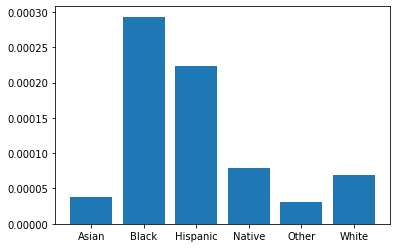

In [38]:
df['arms_category'].value_counts() #Yet, this one wahs a bit too many levels.

#As a sidebar, we observe how does the deaths/population ratio behaves on individuals who were murdered unarmed.
#The reason for this is, if he or she was unnarmed, perhaps other measures could be taken, so death would be indicative of
#a certainb bias towards that individual.
plt.bar(np.arange(6),100*(df[df['arms_category'] == 'Unarmed'].groupby('race').count()['name']/df_total.loc[2015,'Population']))
plt.xticks(np.arange(6),['Asian','Black','Hispanic','Native','Other', 'White'])

#We do see a much higher ratio for Black people, considerably higher than even Hispanics. Yet, we will not use this variable
#on the analysis.

In [39]:
print(df['threat_level'].value_counts()) #This variable will prove useful, given its simplicity to model and the fact that
# killing someone who wasn't 'attacking' (so perhaps robbing, fleeing) might show bias towards that person.

#Given the ambiguity of 'undetermined', and due to the convinience of having a boolean variable, we will create a new column
#on which we will work, in which we will split the level randomly, by the weights of the other two. The new column will be True
#if the individual was attacking, and False otherwise
import random

def split_undetermined(s):
    x = ''
    l = ['attack']*3160 + ['other']*1528
    if s == 'attack':
        x = 'attack'
    elif s == 'other':
        x = 'other'
    else:
        x = random.choice(l)
    return x

df['was_attacking'] = [split_undetermined(x) == 'attack' for x in df['threat_level']]
df['was_attacking'].value_counts()

attack          3160
other           1528
undetermined     207
Name: threat_level, dtype: int64


True     3299
False    1596
Name: was_attacking, dtype: int64

There are some variables which we will not take into account so as to make the model more pasimonius, and because we don't consider them as relevant as the others for the purpose of the analysis. Thus, we make a reduced DF to more easily visualize the variables we will use.

In [40]:
df_log = df[['race','signs_of_mental_illness','was_attacking','was_fleeing','body_camera','Year']]
df_log.head()

,race,signs_of_mental_illness,was_attacking,was_fleeing,body_camera,Year
id,,,,,,
3,Asian,True,True,False,False,2015
4,White,False,True,False,False,2015
5,Hispanic,False,False,False,False,2015
8,White,True,True,False,False,2015
9,Hispanic,False,True,False,False,2015


We have seen a tendency towards Black and Hispanics. However, for the time given, let's consider the analysis of White vs Non White.

In [41]:
df_log['was_white'] = [x == 'White' for x in df_log['race']]
# Also, we scale the Year so that its estimator is relatively more precise: (year - min)/(max - min)
df_log['Year'] = (df_log['Year'] - 2015)/5

X = df_log[['signs_of_mental_illness','was_attacking','was_fleeing','body_camera','Year']]
y = df_log['was_white']

print(X)
print(y)

      signs_of_mental_illness  was_attacking  was_fleeing  body_camera  Year
id                                                                          
3                        True           True        False        False   0.0
4                       False           True        False        False   0.0
5                       False          False        False        False   0.0
8                        True           True        False        False   0.0
9                       False           True        False        False   0.0
...                       ...            ...          ...          ...   ...
5916                    False           True         True         True   1.0
5925                    False           True         True        False   1.0
5918                    False          False        False        False   1.0
5921                    False          False         True        False   1.0
5924                    False           True         True        False   1.0

<ipython-input-41-e9cdcaf58182>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_log['was_white'] = [x == 'White' for x in df_log['race']]
<ipython-input-41-e9cdcaf58182>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_log['Year'] = (df_log['Year'] - 2015)/5


In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

We perform the Logistic Regression. The following code was obtained from: https://realpython.com/logistic-regression-python/

In [49]:
model = LogisticRegression(solver='liblinear', random_state=0).fit(X_train, y_train)

In [51]:
model.classes_

array([False,  True])

In [53]:
model.intercept_

array([-0.1387264])

In [56]:
print(model.coef_)
X.columns

[[ 0.76248812  0.15685323 -0.22488626 -0.4944421   0.10607759]]


Index(['signs_of_mental_illness', 'was_attacking', 'was_fleeing',
       'body_camera', 'Year'],
      dtype='object')

### Notes : 

i. The date for this data is 2015. However, our database has registers spanning from 2015 to 2020. It would be best to acquire data for all years, and get different proportions for every corresponding year.

### Areas of Impovement :
1. An analysis could be performed to verify which of the states seemes to have more racist tendencies.
2. Even though we acquired the coefficients for the logistic regression, we didn't really explore them. A lot could be revealed from the further inspection of these.